# Softmax Classifier 1D

In [1]:
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Dataset, DataLoader

In [2]:
# Create class for plotting data points and decision boundaries for softmax classification

def plot_data(data_set, model = None, n = 1, color = False):
    # Extract input features (X) and labels (Y) from the dataset
    # data_set[:][0] gets all input features from the dataset
    # data_set[:][1] gets all corresponding labels from the dataset
    X = data_set[:][0]  # Shape: [num_samples, 1] - 1D input features
    Y = data_set[:][1]  # Shape: [num_samples] - class labels (0, 1, or 2)
    
    # Plot data points for class 0 (blue circles)
    # X[Y == 0, 0] selects all X values where the label Y equals 0
    # Y[Y == 0] selects all Y values where the label equals 0 (all zeros)
    # 'bo' means blue circles, label creates legend entry
    plt.plot(X[Y == 0, 0].numpy(), Y[Y == 0].numpy(), 'bo', label = 'y = 0')
    
    # Plot data points for class 1 (red circles)
    # X[Y == 1, 0] selects all X values where the label Y equals 1
    # 0 * Y[Y == 1] creates zeros for y-axis (flattens points to x-axis)
    # This puts all class 1 points on the x-axis at y=0
    plt.plot(X[Y == 1, 0].numpy(), 0 * Y[Y == 1].numpy(), 'ro', label = 'y = 1')
    
    # Plot data points for class 2 (green circles)
    # X[Y == 2, 0] selects all X values where the label Y equals 2
    # 0 * Y[Y == 2] creates zeros for y-axis (flattens points to x-axis)
    # This puts all class 2 points on the x-axis at y=0
    plt.plot(X[Y == 2, 0].numpy(), 0 * Y[Y == 2].numpy(), 'go', label = 'y = 2')
    
    # Set y-axis limits to show a small range around 0
    # This ensures we can see the data points and decision boundaries clearly
    plt.ylim((-0.1, 3))
    
    # Display legend showing which color represents which class
    plt.legend()
    
    # If a trained model is provided, plot the decision boundaries
    if model != None:
        # Extract the first layer's weight and bias parameters
        # list(model.parameters())[0] gets the weight matrix
        # list(model.parameters())[1] gets the bias vector
        # [0] selects the first row (for class 0), .detach() removes gradient tracking
        w = list(model.parameters())[0][0].detach()  # Weight for class 0
        b = list(model.parameters())[1][0].detach()  # Bias for class 0
        
        # Define labels and colors for each class's decision boundary
        y_label = ['yhat=0', 'yhat=1', 'yhat=2']  # Legend labels for predictions
        y_color = ['b', 'r', 'g']  # Colors: blue, red, green
        
        # List to store the linear decision boundary equations for each class
        Y = []
        
        # Iterate through each class's parameters to plot decision boundaries
        # model.state_dict()['0.weight'] gets all weight rows [3, 1] for 3 classes
        # model.state_dict()['0.bias'] gets all bias values [3] for 3 classes
        for w, b, y_l, y_c in zip(model.state_dict()['0.weight'], 
                                  model.state_dict()['0.bias'], 
                                  y_label, 
                                  y_color):
            # Calculate linear function: y = w*x + b for each class
            # This represents the raw score (logit) for each class
            Y.append((w * X + b).numpy())  # Store the linear function values
            
            # Plot the decision boundary line for this class
            # X.numpy() converts tensor to numpy for plotting
            # (w * X + b).numpy() calculates the line equation
            plt.plot(X.numpy(), (w * X + b).numpy(), y_c, label = y_l)
        
        # If color flag is True, fill regions between decision boundaries
        if color == True:
            # Prepare data for region filling
            x = X.numpy()  # Convert input features to numpy array
            x = x.reshape(-1)  # Flatten to 1D array for fill_between function
            top = np.ones(x.shape)  # Create array of ones (not used in this code)
            
            # Extract the three decision boundary lines
            y0 = Y[0].reshape(-1)  # Class 0 decision boundary (flattened)
            y1 = Y[1].reshape(-1)  # Class 1 decision boundary (flattened)
            y2 = Y[2].reshape(-1)  # Class 2 decision boundary (flattened)
            
            # Fill region where class 0 has highest score (blue region)
            # where = y1 > y1 is always False (typo in original code?)
            plt.fill_between(x, y0, where = y1 > y1, interpolate = True, color = 'blue')
            # Fill where class 0 score > class 2 score (blue region)
            plt.fill_between(x, y0, where = y1 > y2, interpolate = True, color = 'blue')
            
            # Fill region where class 1 has highest score (red region)
            # where = y1 > y0 means class 1 score > class 0 score
            plt.fill_between(x, y1, where = y1 > y0, interpolate = True, color = 'red')
            # Fill where class 1 beats both other classes
            plt.fill_between(x, y1, where = ((y1 > y2) * (y1 > y0)), interpolate = True, color = 'red')
            
            # Fill region where class 2 has highest score (green region)
            # where = (y2 > y0) * (y0 > 0) means class 2 > class 0 AND class 0 > 0
            plt.fill_between(x, y2, where = (y2 > y0) * (y0 > 0), interpolate = True, color = 'green')
            # Fill where class 2 score > class 1 score
            plt.fill_between(x, y2, where = (y2 > y1), interpolate = True, color = 'green')
    
    # Display legend again to include decision boundary labels
    plt.legend()
    
    # Show the complete plot with data points and decision boundaries
    plt.show()

In [3]:
torch.manual_seed(0)

In [4]:
# Create the data class for generating a 1D multi-class classification dataset

class Data(Dataset):
    """
    Custom Dataset class for creating 1D synthetic data with 3 classes
    Inherits from torch.utils.data.Dataset for compatibility with DataLoader
    Data distribution:
    - Class 0: x < -1.0 (left region)
    - Class 1: -1.0 <= x < 1.0 (middle region) 
    - Class 2: x >= 1.0 (right region)
    """
    # Constructor - initializes the dataset when an instance is created
    def __init__(self):
        """
        Initialize the synthetic 1D dataset with 3 classes
        Creates input features (x) and corresponding labels (y)
        """
        # Create input features: range from -2 to 2 with step size 0.1
        # torch.arange(-2, 2, 0.1) creates 1D tensor: [-2.0, -1.9, -1.8, ..., 1.8, 1.9]
        # .view(-1, 1) reshapes from [40] to [40, 1] - makes it a column vector
        # This gives us 40 samples, each with 1 feature
        self.x = torch.arange(-2, 2, 0.1).view(-1, 1)
        
        # Initialize all labels to 0 (class 0 by default)
        # torch.zeros(self.x.shape[0]) creates tensor of zeros with same length as x
        # self.x.shape[0] gives the number of samples (40 in this case)
        self.y = torch.zeros(self.x.shape[0])
        
        # Assign class 1 to samples in the middle region (-1.0 <= x < 1.0)
        # (self.x > -1.0)[:, 0] creates boolean mask for x > -1.0
        # (self.x < 1.0)[:, 0] creates boolean mask for x < 1.0
        # * performs element-wise AND operation on the boolean masks
        # The [:, 0] extracts the first (only) column from the 2D tensor
        # Result: boolean mask that's True where -1.0 <= x < 1.0
        self.y[(self.x > -1.0)[:, 0] * (self.x < 1.0)[:, 0]] = 1
        
        # Assign class 2 to samples in the right region (x >= 1.0)
        # (self.x >= 1.0)[:, 0] creates boolean mask for x >= 1.0
        # [:, 0] extracts the first column to get 1D boolean tensor
        # All samples where x >= 1.0 get assigned label 2
        self.y[(self.x >= 1.0)[:, 0]] = 2
        
        # Convert labels to LongTensor (required for CrossEntropyLoss)
        # PyTorch's classification loss functions expect integer labels as LongTensor
        # .type(torch.LongTensor) converts from FloatTensor to LongTensor
        self.y = self.y.type(torch.LongTensor)
        
        # Store the dataset length (number of samples)
        # self.x.shape[0] gives the number of rows in the input tensor
        # This will be used by the __len__ method
        self.len = self.x.shape[0]
        
    # Getter method - required by PyTorch Dataset interface
    def __getitem__(self, index):
        """
        Get a single sample from the dataset by index
        
        Args:
            index (int): Index of the sample to retrieve
            
        Returns:
            tuple: (input_feature, label) for the sample at given index
        """
        # Return a tuple containing the input feature and corresponding label
        # self.x[index] gets the input feature at the specified index
        # self.y[index] gets the label at the specified index
        # This follows PyTorch's dataset convention of returning (input, target)
        return self.x[index], self.y[index]
    
    # Get Length method - required by PyTorch Dataset interface
    def __len__(self):
        """
        Return the total number of samples in the dataset
        
        Returns:
            int: Total number of samples
        """
        # Return the stored length of the dataset
        # This is used by DataLoader to know how many samples exist
        # Also used for iteration and batching
        return self.len

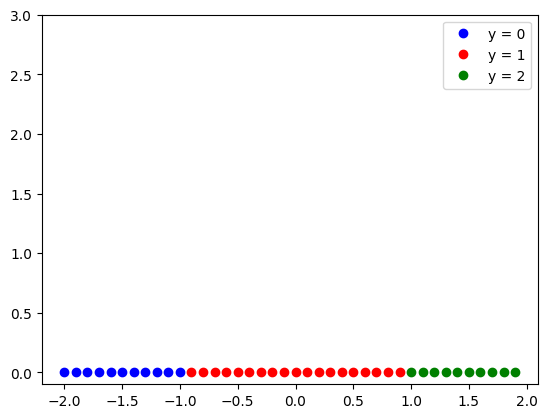

In [ ]:
# Creating the dataset object

data_set = Data()
data_set.x
plot_data(data_set)

In [7]:
# Building a Softmax Classifier

model = nn.Sequential(nn.Linear(1,3))
model.state_dict()

OrderedDict([('0.weight',
              tensor([[-0.0075],
                      [ 0.5364],
                      [-0.8230]])),
             ('0.bias', tensor([-0.7359, -0.3852,  0.2682]))])

In [ ]:
# Setting up criterion, optimizer, and dataloader to train the model    

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
trainloader = DataLoader(dataset = data_set, batch_size=5)

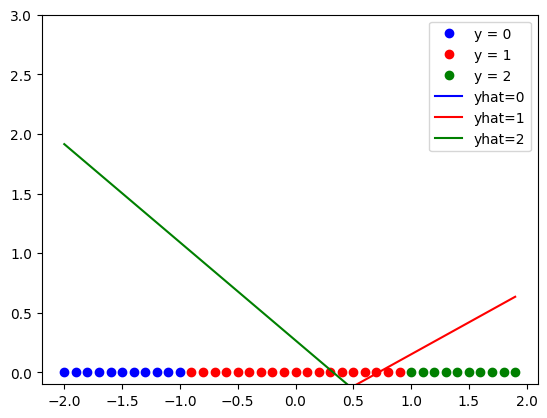

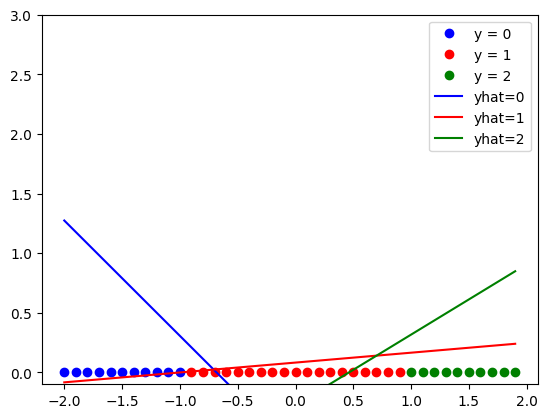

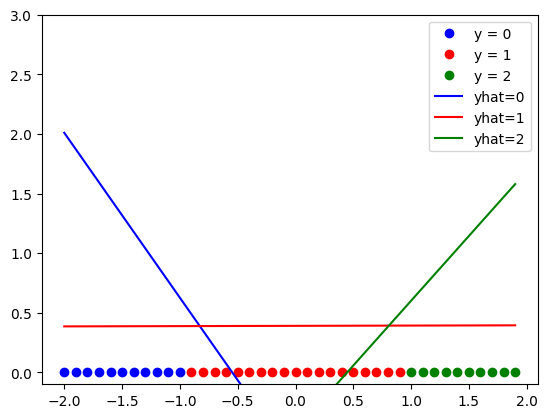

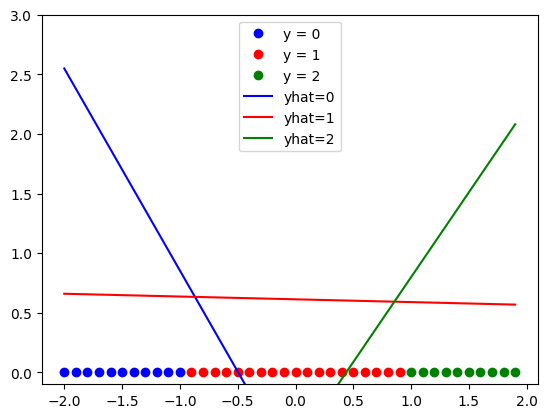

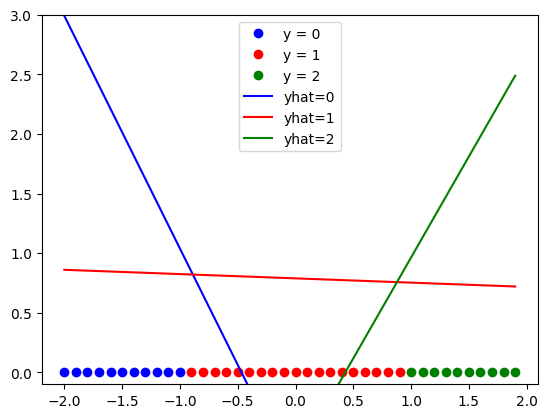

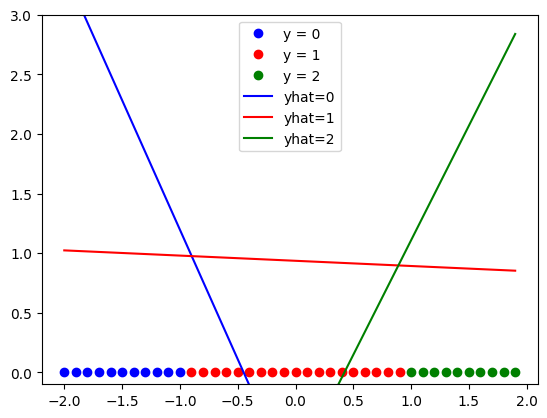

In [11]:
# Training the model

LOSS = []
def train_model(epochs):
    for epoch in range(epochs):
        if epoch % 50 == 0:
            pass 
            plot_data(data_set, model)
        for x, y in trainloader:
            optimizer.zero_grad()
            yhat = model(x)
            loss = criterion(yhat, y)
            LOSS.append(loss)
            loss.backward()
            optimizer.step()
train_model(300)

In [12]:
#  Analyzing the Reults by finding the predicted class

z = model(data_set.x)
_, yhat = z.max(1)
print("The prediction: ", yhat)

The prediction:  tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])


In [15]:
# Printing the Accuracy

correct = (data_set.y == yhat).sum().item()
accuracy = correct / len(data_set)
print("The accuracy: ", accuracy)

The accuracy:  0.975


In [20]:
# Softmax to convert the output to a probablity

Softmax_fn = nn.Softmax(dim=-1)
Probability = Softmax_fn(z)

for i in range(3):
    print("Probability of class {} is given by {}".format(i, Probability[0,i]) )

Probability of class 0 is given by 0.9267547726631165
Probability of class 1 is given by 0.07310982048511505
Probability of class 2 is given by 0.00013548224524129182
